In [1]:
# Training variables
rolling_mean = 7

## Import data from AWS S3

In [2]:
import sys
sys.path.insert(0, '/home/khiem/Dropbox/Education/Drexel/DSCI-591/Project/Walmart-Strategic-Sales-Forecasting')

In [3]:
import boto3
import pandas as pd

bucket = 'dsci-632'

s3 = boto3.client('s3')
obj = s3.get_object(Bucket="dsci-632", Key="CA_1_sales_data.csv")
df = pd.read_csv(obj['Body'], index_col=0, parse_dates=True) # 'Body' is a keyword
print(df.head())

            wm_yr_wk  wday  month  year event_name_1 event_type_1  \
2011-01-29     11101     1      1  2011         None         None   
2011-01-30     11101     2      1  2011         None         None   
2011-01-31     11101     3      1  2011         None         None   
2011-02-01     11101     4      2  2011         None         None   
2011-02-02     11101     5      2  2011         None         None   

           event_name_2 event_type_2      cpi  unemployment_rate  gas_price  \
2011-01-29         None         None  221.187                9.1      3.163   
2011-01-30         None         None  221.187                9.1      3.163   
2011-01-31         None         None  221.187                9.1      3.155   
2011-02-01         None         None  221.898                9.0      3.155   
2011-02-02         None         None  221.898                9.0      3.155   

            snap_ca  ca_walmart  ca_hobbies  ca_household  ca_foods  \
2011-01-29        0       39.50       2

## Data Processing

In [4]:
from data_processing.pre_modeling import pre_modeling

df_processed = pre_modeling(df)

## Data Analysis

In [5]:
timeseries_cols = ['cpi', 'unemployment_rate', 'gas_price', 'ca_walmart', 'ca_hobbies', 'ca_household', 'ca_foods', 'median_price', 'min_price', 'max_price']
time_cols = ['wm_yr_wk', 'wday', 'day', 'month', 'year']
target_col = ['store_sales']
cat_cols = [col for col in df_processed.columns if col not in timeseries_cols + time_cols + target_col] # extract the remaining columns

In [6]:
df_used = df_processed[timeseries_cols+time_cols+cat_cols+target_col]
df_used = df_used.rolling(rolling_mean).mean().dropna()

In [7]:
nobs = 30
df_original = df_used
df_test = df_used[-nobs:]
df_train = df_used[0:-nobs]

print(df_train.columns)

Index(['cpi', 'unemployment_rate', 'gas_price', 'ca_walmart', 'ca_hobbies',
       'ca_household', 'ca_foods', 'median_price', 'min_price', 'max_price',
       'wm_yr_wk', 'wday', 'day', 'month', 'year', 'snap_ca',
       'event_name_1_chanukah end', 'event_name_1_christmas',
       'event_name_1_cinco de mayo', 'event_name_1_columbusday',
       'event_name_1_easter', 'event_name_1_eid al-fitr',
       'event_name_1_eidaladha', 'event_name_1_father's day',
       'event_name_1_halloween', 'event_name_1_independenceday',
       'event_name_1_laborday', 'event_name_1_lentstart',
       'event_name_1_lentweek2', 'event_name_1_martinlutherkingday',
       'event_name_1_memorialday', 'event_name_1_mother's day',
       'event_name_1_nbafinalsend', 'event_name_1_nbafinalsstart',
       'event_name_1_newyear', 'event_name_1_none',
       'event_name_1_orthodoxchristmas', 'event_name_1_orthodoxeaster',
       'event_name_1_pesach end', 'event_name_1_presidentsday',
       'event_name_1_purim 

In [8]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 

    if p_value > sig:
        return True
    else:
        return False

def adfuller_test_all(df, sig=0.05):
    non_stationary = []
    stationary = []
    for name, column in df_train.iteritems():
        if adfuller_test(column, name=column.name):
            non_stationary.append(column.name)
        else:
            stationary.append(column.name)

    print('Non-stationary:', non_stationary)
    print('Stationary:', stationary)

adfuller_test_all(df_train)

/home/khiem/.local/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Non-stationary: ['cpi', 'unemployment_rate', 'gas_price', 'median_price', 'min_price', 'max_price', 'wm_yr_wk', 'year', 'store_sales']
Stationary: ['ca_walmart', 'ca_hobbies', 'ca_household', 'ca_foods', 'wday', 'day', 'month', 'snap_ca', 'event_name_1_chanukah end', 'event_name_1_christmas', 'event_name_1_cinco de mayo', 'event_name_1_columbusday', 'event_name_1_easter', 'event_name_1_eid al-fitr', 'event_name_1_eidaladha', "event_name_1_father's day", 'event_name_1_halloween', 'event_name_1_independenceday', 'event_name_1_laborday', 'event_name_1_lentstart', 'event_name_1_lentweek2', 'event_name_1_martinlutherkingday', 'event_name_1_memorialday', "event_name_1_mother's day", 'event_name_1_nbafinalsend', 'event_name_1_nbafinalsstart', 'event_name_1_newyear', 'event_name_1_none', 'event_name_1_orthodoxchristmas', 'event_name_1_orthodoxeaster', 'event_name_1_pesach end', 'event_name_1_presidentsday', 'event_name_1_purim end', 'event_name_1_ramadan starts', 'event_name_1_stpatricksday', 

In [9]:
df_train = df_train.diff().dropna()
adfuller_test_all(df_train)

/home/khiem/.local/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Non-stationary: []
Stationary: ['cpi', 'unemployment_rate', 'gas_price', 'ca_walmart', 'ca_hobbies', 'ca_household', 'ca_foods', 'median_price', 'min_price', 'max_price', 'wm_yr_wk', 'wday', 'day', 'month', 'year', 'snap_ca', 'event_name_1_chanukah end', 'event_name_1_christmas', 'event_name_1_cinco de mayo', 'event_name_1_columbusday', 'event_name_1_easter', 'event_name_1_eid al-fitr', 'event_name_1_eidaladha', "event_name_1_father's day", 'event_name_1_halloween', 'event_name_1_independenceday', 'event_name_1_laborday', 'event_name_1_lentstart', 'event_name_1_lentweek2', 'event_name_1_martinlutherkingday', 'event_name_1_memorialday', "event_name_1_mother's day", 'event_name_1_nbafinalsend', 'event_name_1_nbafinalsstart', 'event_name_1_newyear', 'event_name_1_none', 'event_name_1_orthodoxchristmas', 'event_name_1_orthodoxeaster', 'event_name_1_pesach end', 'event_name_1_presidentsday', 'event_name_1_purim end', 'event_name_1_ramadan starts', 'event_name_1_stpatricksday', 'event_name_1

In [10]:
from statsmodels.tsa.api import VAR

df_train_fit = df_train[timeseries_cols+target_col]
model = VAR(df_train_fit)
x = model.select_order(maxlags=12)
x.summary()

/home/khiem/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-45.77,-45.74,1.325e-20,-45.76
1,-55.38,-54.99*,8.917e-25,-55.23
2,-55.41,-54.66,8.664e-25,-55.13
3,-55.42,-54.32,8.563e-25,-55.01
4,-55.42,-53.97,8.516e-25,-54.89
5,-55.43,-53.63,8.443e-25,-54.77
6,-55.51,-53.35,7.821e-25,-54.71
7,-56.48,-53.97,2.951e-25,-55.56
8,-57.69*,-54.82,8.805e-26*,-56.64*
9,-57.65,-54.42,9.215e-26,-56.46


In [11]:
model_fitted = model.fit(7)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 18, Jul, 2022
Time:                     00:00:42
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -53.9011
Nobs:                     1897.00    HQIC:                  -55.4866
Log likelihood:           24754.3    FPE:                3.17297e-25
AIC:                     -56.4105    Det(Omega_mle):     2.03690e-25
--------------------------------------------------------------------
Results for equation cpi
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.003208         0.000498            6.438           0.000
L1.cpi                       0.847316         0.024385           34.748           0.000
L1.unemployment_rate         0.029

In [12]:
print(model_fitted.params["store_sales"])

const                     -2.606516
L1.cpi                   201.600649
L1.unemployment_rate    -745.801820
L1.gas_price            -135.246691
L1.ca_walmart             -2.065577
                           ...     
L7.ca_foods                0.931429
L7.median_price         1694.695439
L7.min_price             220.740196
L7.max_price              10.460342
L7.store_sales            -0.436995
Name: store_sales, Length: 78, dtype: float64


In [13]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = df_train_fit.values[-lag_order:]
forecast_input

7


array([[ 0.00000000e+00,  0.00000000e+00, -1.71428571e-03,
        -2.05714286e-01,  5.14285714e-02,  1.05857143e+00,
         1.03714286e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -9.64285714e+01],
       [ 0.00000000e+00,  0.00000000e+00, -1.71428571e-03,
         3.60000000e-01, -7.71428571e-01, -1.30285714e+00,
         2.82857143e-01,  4.44089210e-16,  2.77555756e-17,
         0.00000000e+00, -2.14285714e+00],
       [ 0.00000000e+00,  0.00000000e+00,  9.57142857e-03,
        -2.05714286e-01, -5.14285714e-02,  1.22142857e+00,
         8.48571429e-01, -4.44089210e-16,  0.00000000e+00,
         0.00000000e+00, -1.98571429e+01],
       [ 0.00000000e+00,  0.00000000e+00,  9.57142857e-03,
        -1.02857143e-01,  1.69714286e+00, -8.95714286e-01,
         8.48571429e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  3.05714286e+01],
       [-2.84217094e-14,  0.00000000e+00,  9.57142857e-03,
         4.11428571e-01,  6.17142857e-01, -7.32857143e-01,
  

In [14]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_original.index[-nobs:], columns=df_train_fit.columns + '_1d')
df_forecast["store_sales_1d"]

2016-04-23    51.917431
2016-04-24    14.713215
2016-04-25    18.654576
2016-04-26   -12.581806
2016-04-27   -19.562945
2016-04-28    -7.800391
2016-04-29   -32.703492
2016-04-30   -26.225909
2016-05-01    -8.740503
2016-05-02   -12.428143
2016-05-03     6.863580
2016-05-04    11.765234
2016-05-05     6.923285
2016-05-06    19.738504
2016-05-07    14.484093
2016-05-08     6.190414
2016-05-09     7.709842
2016-05-10    -4.411265
2016-05-11    -8.134796
2016-05-12    -7.215564
2016-05-13   -14.227065
2016-05-14   -10.858124
2016-05-15    -7.179732
2016-05-16    -7.431886
2016-05-17     0.069594
2016-05-18     3.082992
2016-05-19     4.226979
2016-05-20     8.673359
2016-05-21     7.261068
2016-05-22     6.304748
Name: store_sales_1d, dtype: float64

In [15]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(df_original[0:-nobs][timeseries_cols+target_col], df_forecast)        
df_results.head(10)

,cpi_1d,unemployment_rate_1d,gas_price_1d,ca_walmart_1d,ca_hobbies_1d,ca_household_1d,ca_foods_1d,median_price_1d,min_price_1d,max_price_1d,...,unemployment_rate_forecast,gas_price_forecast,ca_walmart_forecast,ca_hobbies_forecast,ca_household_forecast,ca_foods_forecast,median_price_forecast,min_price_forecast,max_price_forecast,store_sales_forecast
2016-04-23,0.003833,-0.000058,0.009190,0.224022,0.044405,-0.747453,0.250359,0.000152,0.000006,0.005471,...,5.099942,2.230047,29.178307,29.821548,38.826833,60.310359,3.480152,0.230006,29.975471,4530.060288
2016-04-24,0.011179,-0.001526,0.008914,0.207352,0.476671,0.341397,0.529827,0.000321,0.000010,0.008466,...,5.098416,2.238962,29.385659,30.298219,39.168230,60.840186,3.480473,0.230016,29.983937,4544.773503
2016-04-25,0.016921,-0.001581,0.008368,0.247277,-0.041256,-0.930339,-0.023534,0.000491,-0.000304,0.001161,...,5.096835,2.247330,29.632936,30.256963,38.237891,60.816652,3.480964,0.229712,29.985098,4563.428079
2016-04-26,0.019909,-0.001943,0.007775,0.173278,-0.803798,0.231265,-0.230934,0.000411,-0.000469,-0.000445,...,5.094892,2.255105,29.806214,29.453165,38.469156,60.585718,3.481375,0.229243,29.984652,4550.846273
2016-04-27,0.026416,-0.002915,0.007009,-0.069767,-0.546541,-0.157258,-0.144845,0.000377,-0.000358,0.000561,...,5.091977,2.262114,29.736448,28.906624,38.311897,60.440873,3.481753,0.228884,29.985213,4531.283328
2016-04-28,0.028222,-0.003335,0.006602,-0.160508,0.636401,0.241263,-0.175506,0.000407,-0.000609,-0.001485,...,5.088642,2.268716,29.575939,29.543025,38.553160,60.265367,3.482160,0.228276,29.983727,4523.482936
2016-04-29,0.029313,-0.003488,0.006197,-0.113617,-0.245741,1.514516,-0.242306,0.000401,-0.000432,-0.002460,...,5.085154,2.274913,29.462322,29.297284,40.067677,60.023061,3.482561,0.227843,29.981268,4490.779444
2016-04-30,0.031311,-0.003865,0.005781,-0.217860,-0.218430,0.446888,-0.320147,0.000405,-0.000247,-0.005374,...,5.081289,2.280694,29.244462,29.078854,40.514565,59.702913,3.482966,0.227596,29.975894,4464.553535
2016-05-01,0.031123,-0.003859,0.005218,-0.253749,-0.313272,0.005353,-0.432041,0.000332,-0.000284,-0.007948,...,5.077430,2.285912,28.990713,28.765582,40.519918,59.270873,3.483297,0.227312,29.967946,4455.813032
2016-05-02,0.029979,-0.004060,0.004694,-0.255006,-0.141309,0.529067,-0.197430,0.000204,-0.000139,-0.005053,...,5.073370,2.290607,28.735706,28.624273,41.048986,59.073443,3.483502,0.227173,29.962893,4443.384889


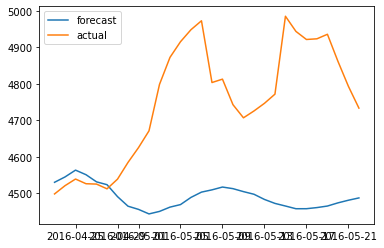

In [16]:
import matplotlib.pyplot as plt

plt.plot(df_results.index, df_results["store_sales_forecast"], label = "forecast")
plt.plot(df_test.index, df_test["store_sales"], label = "actual")
plt.legend()
plt.show()


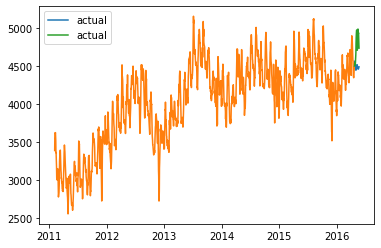

In [17]:
plt.plot(df_results["store_sales_forecast"].index, df_results["store_sales_forecast"], label = "actual")
plt.plot(df_original["store_sales"][0:-nobs].index, df_original["store_sales"][0:-nobs])
plt.plot(df_test.index, df_test["store_sales"], label = "actual")
plt.legend()
plt.show()

In [18]:
# evaluate the model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

error_mse = mean_squared_error(df_test["store_sales"], df_results["store_sales_forecast"])
error_mae = mean_absolute_error(df_test["store_sales"], df_results["store_sales_forecast"])
error_r2 = r2_score(df_test["store_sales"], df_results["store_sales_forecast"])
print("MSE:", error_mse)
print("MAE:", error_mae)
print("R2:", error_r2)


MSE: 98911.86597023379
MAE: 266.21556505095674
R2: -2.921751825206288
